## Machine Learning Model Training

**Dataset path:** `../data/raw/StressLevelDataset.csv`

In [1]:
#================================================================
# Add all the libraries imports needed in the project here
#================================================================
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.feature_selection import VarianceThreshold
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Use imblearn Pipeline for pipelines WITH a sampler step
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import os, re, json, joblib

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if your notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

#================================================================
# Imports custom preprocessing functions from 'functions.py'
#================================================================

from lib.functions import (is_binary_like,
                        _pretty_p,
                        evaluate_classifier,
                        run_models_with_importances,
                        feature_importances_dataframe
                        )

#================================================================
#  Initialize config
#================================================================
config = None
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")
    
# =============================================================================
# DATA LOADING
# =============================================================================
df = pd.read_csv(config['input_data']['file1'])

**1) Quick checks**

In [2]:
display(df.head())
display(df.shape)
display(df.dtypes)
display(df.isna().sum())


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


(1100, 21)

anxiety_level                   int64
self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
future_career_concerns          int64
social_support                  int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object

anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

**2) Detect numeric, binary-like, and categorical columns**

In [3]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
print('Numeric (non-binary-like):', num_cols)
print('Binary-like:', binary_like)
print('Categorical:', cat_cols)

Numeric (non-binary-like): ['anxiety_level', 'self_esteem', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']
Binary-like: ['mental_health_history']
Categorical: []


**3) Train/Test split & preprocessing**

In [4]:
target = 'stress_level'
X = df.drop(columns=[target])
y = df[target]

num_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((880, 20), (220, 20))

# KNN (Supervised ML)

**4) Fit KNN and evaluate**

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([('prep', preprocess), ('model', knn)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_classifier(y_test, y_pred, title='KNN (k=5)')      # accuracy + confusion + per-class precision/recall/F1 

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    m.fit(X_train, y_train)
    yp = m.predict(X_test)
    print(f'k={k}: Acc={round(accuracy_score(y_test, yp),4)}')
    
print('')

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    cv = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f'k={k}: CV accuracy={cv:.4f}')


=== KNN (k=5) ===
Accuracy: 0.8545

Confusion matrix:
[[60 10  4]
 [ 2 66  4]
 [ 7  5 62]]

Classification report:
              precision    recall  f1-score   support

           0     0.8696    0.8108    0.8392        74
           1     0.8148    0.9167    0.8627        72
           2     0.8857    0.8378    0.8611        74

    accuracy                         0.8545       220
   macro avg     0.8567    0.8551    0.8543       220
weighted avg     0.8571    0.8545    0.8543       220

k=3: Acc=0.8545
k=5: Acc=0.8545
k=7: Acc=0.8409
k=9: Acc=0.85
k=11: Acc=0.85

k=3: CV accuracy=0.8750
k=5: CV accuracy=0.8739
k=7: CV accuracy=0.8784
k=9: CV accuracy=0.8693
k=11: CV accuracy=0.8693


**5) Simple pre-selection (VarianceThreshold) & Save pipeline**

In [6]:
vt = VarianceThreshold(threshold=0.0)
vt_pipe = Pipeline([('prep', preprocess), ('vt', vt)])
Xt = vt_pipe.fit_transform(X_train)
print('Transformed shape:', Xt.shape)

clf = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
clf.fit(X_train, y_train)
# with open('stress_pipeline.pkl','wb') as f:
#     pickle.dump(clf, f)
# print('Saved stress_pipeline.pkl')

Transformed shape: (880, 20)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Supervised ML (Core Models and Metrics)

**6) Train Logistic Regression, KNN, Decision Tree**

In [7]:
models = {
    'KNN(k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

results = run_models_with_importances(
    models=models,
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)

=== KNN(k=5) ===
Accuracy: 0.8545

Confusion matrix:
[[59  9  6]
 [ 2 66  4]
 [ 6  5 63]]

Classification report:
              precision    recall  f1-score   support

           0     0.8806    0.7973    0.8369        74
           1     0.8250    0.9167    0.8684        72
           2     0.8630    0.8514    0.8571        74

    accuracy                         0.8545       220
   macro avg     0.8562    0.8551    0.8541       220
weighted avg     0.8565    0.8545    0.8540       220

KNN(k=5): no native feature_importances_ or coef_ (skipping top-features).

=== LogisticRegression ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821

,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.455814,-2.800922,1.345108,1.867281
15,num__social_support,1.064782,-1.343949,0.279167,0.895966
19,remainder__mental_health_history,0.395030,-0.574510,0.179481,0.383007
1,num__self_esteem,0.190348,0.255073,-0.445421,0.296947
11,num__academic_performance,0.387103,-0.044463,-0.342640,0.258069
12,num__study_load,-0.368665,0.258219,0.110446,0.245777
13,num__teacher_student_relationship,0.205090,-0.362360,0.157270,0.241573
10,num__basic_needs,0.347154,-0.229818,-0.117336,0.231436
3,num__headache,-0.228626,-0.081550,0.310176,0.206784
5,num__sleep_quality,0.150039,0.068295,-0.218333,0.145556


=== DecisionTree ===
Accuracy: 0.8591

Confusion matrix:
[[61  7  6]
 [ 6 64  2]
 [ 4  6 64]]

Classification report:
              precision    recall  f1-score   support

           0     0.8592    0.8243    0.8414        74
           1     0.8312    0.8889    0.8591        72
           2     0.8889    0.8649    0.8767        74

    accuracy                         0.8591       220
   macro avg     0.8597    0.8594    0.8591       220
weighted avg     0.8600    0.8591    0.8591       220


Top 10 features for DecisionTree:


,feature,importance
4,num__blood_pressure,0.375749
11,num__academic_performance,0.343133
5,num__sleep_quality,0.044360
13,num__teacher_student_relationship,0.043331
8,num__living_conditions,0.031277
9,num__safety,0.026165
10,num__basic_needs,0.023637
2,num__depression,0.019776
15,num__social_support,0.014540
1,num__self_esteem,0.013738


**6.1) Uniform comparison table**

In [8]:
rows = []
for name, est in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', est)])
    pipe.fit(X_train, y_train)
    yp = pipe.predict(X_test)
    rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, yp),
        'balanced_acc': balanced_accuracy_score(y_test, yp),
        'macro_f1': f1_score(y_test, yp, average='macro')
    })
pd.DataFrame(rows).sort_values('macro_f1', ascending=False)

,model,accuracy,balanced_acc,macro_f1
1,LogisticRegression,0.881818,0.882132,0.881955
2,DecisionTree,0.859091,0.859359,0.859051
0,KNN(k=5),0.854545,0.855105,0.854148


# Ensembles (Random Forest, Gradient Boosting and AdaBoost)

**7) Fit and evaluate ensembles**

In [9]:
# 1) RandomForestClassifier
results_base = run_models_with_importances(
    models={'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 2) GradientBoostingClassifier
results_base = run_models_with_importances(
    models={'Gradient Boosting': GradientBoostingClassifier(random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 3) AdaBoostClassifier
results_base = run_models_with_importances(
    models={'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)

=== Random Forest ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 4 65  3]
 [ 5  3 66]]

Classification report:
              precision    recall  f1-score   support

           0     0.8750    0.8514    0.8630        74
           1     0.8904    0.9028    0.8966        72
           2     0.8800    0.8919    0.8859        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8820    0.8818       220
weighted avg     0.8817    0.8818    0.8817       220


Top 10 features for Random Forest:


,feature,importance
4,num__blood_pressure,0.121358
13,num__teacher_student_relationship,0.078934
11,num__academic_performance,0.074508
5,num__sleep_quality,0.073114
2,num__depression,0.071477
15,num__social_support,0.065580
18,num__bullying,0.057219
0,num__anxiety_level,0.055405
14,num__future_career_concerns,0.052372
17,num__extracurricular_activities,0.051341


=== Gradient Boosting ===
Accuracy: 0.8773

Confusion matrix:
[[61  7  6]
 [ 1 67  4]
 [ 6  3 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8971    0.8243    0.8592        74
           1     0.8701    0.9306    0.8993        72
           2     0.8667    0.8784    0.8725        74

    accuracy                         0.8773       220
   macro avg     0.8780    0.8778    0.8770       220
weighted avg     0.8780    0.8773    0.8768       220


Top 10 features for Gradient Boosting:


,feature,importance
4,num__blood_pressure,0.262686
5,num__sleep_quality,0.236636
11,num__academic_performance,0.152462
13,num__teacher_student_relationship,0.115943
10,num__basic_needs,0.031455
15,num__social_support,0.026965
1,num__self_esteem,0.026631
3,num__headache,0.018744
0,num__anxiety_level,0.018189
17,num__extracurricular_activities,0.017924


=== AdaBoost ===
Accuracy: 0.8864

Confusion matrix:
[[59  6  9]
 [ 1 67  4]
 [ 4  1 69]]

Classification report:
              precision    recall  f1-score   support

           0     0.9219    0.7973    0.8551        74
           1     0.9054    0.9306    0.9178        72
           2     0.8415    0.9324    0.8846        74

    accuracy                         0.8864       220
   macro avg     0.8896    0.8868    0.8858       220
weighted avg     0.8894    0.8864    0.8855       220


Top 10 features for AdaBoost:


,feature,importance
4,num__blood_pressure,0.304251
1,num__self_esteem,0.224047
15,num__social_support,0.125452
13,num__teacher_student_relationship,0.044484
11,num__academic_performance,0.038126
12,num__study_load,0.035036
5,num__sleep_quality,0.033194
3,num__headache,0.026049
2,num__depression,0.023973
17,num__extracurricular_activities,0.020929


# Hyperparameter Tuning

**8) Tuning RandomForest, GradientBoosting and AdaBoost (GridSearchCV)**

**RandomForestClassifier**

In [10]:
rf_baseline  = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_rf = GridSearchCV(rf_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print('Best params (RF):', gs_rf.best_params_)
best_rf = gs_rf.best_estimator_

best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print('Test accuracy (best tuned RF):', round(accuracy_score(y_test, pred),4))

Best params (RF): {'model__max_depth': 50, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 4, 'model__n_estimators': 50}
Test accuracy (best tuned RF): 0.8818


**GradientBoostingClassifier**

In [11]:
gb_baseline  = Pipeline([('prep', preprocess), ('model', GradientBoostingClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0],
    'model__max_depth': [10, 50],
    'model__min_samples_split': [4, 16],
    'model__max_leaf_nodes': [250, 1000],
    'model__max_features': ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_gbc = GridSearchCV(gb_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_gbc.fit(X_train, y_train)
print('Best params (Grid):', gs_gbc.best_params_)
best_gbc = gs_gbc.best_estimator_

best_gbc.fit(X_train, y_train)
pred = best_gbc.predict(X_test)
print('Test accuracy (best tuned GB):', round(accuracy_score(y_test, pred),4))

Best params (Grid): {'model__learning_rate': 1.0, 'model__max_depth': 50, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 250, 'model__min_samples_split': 16, 'model__n_estimators': 50}
Test accuracy (best tuned GB): 0.8909


**AdaBoostClassifier**

In [12]:
ada_baseline  = Pipeline([('prep', preprocess), ('model', AdaBoostClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [50, 500],
    'model__learning_rate': [0.05, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_ada = GridSearchCV(ada_baseline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)
print("AdaBoost best params:", gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
print('Test accuracy (best tuned ADA):', round(accuracy_score(y_test, pred),4))

AdaBoost best params: {'model__learning_rate': 1.0, 'model__n_estimators': 50}
Test accuracy (best tuned ADA): 0.8864


# Imbalanced Data (Multi-class)

**9) Class distribution**

In [13]:
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))

stress_level
0    0.340
2    0.335
1    0.325
Name: proportion, dtype: float64
stress_level
0    0.336
2    0.336
1    0.327
Name: proportion, dtype: float64


**10) Baseline Logistic Regression and resampling variants**

In [14]:
# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Baseline LogReg': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=False,
    save_csv=False
)
# 2) Oversample (ROS) -> imblearn Pipeline + RandomOverSampler
results_ros = run_models_with_importances(
    models={'LogReg + ROS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomOverSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)
# 3) Undersample (RUS)
results_rus = run_models_with_importances(
    models={'LogReg + RUS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomUnderSampler(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)
# 4) SMOTE
results_smt = run_models_with_importances(
    models={'LogReg + SMOTE': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=SMOTE(random_state=42),
    top=10,
    plot=False,
    save_csv=False
)

=== Baseline LogReg ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for Baseline LogReg:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.455814,-2.800922,1.345108,1.867281
15,num__social_support,1.064782,-1.343949,0.279167,0.895966
19,remainder__mental_health_history,0.395030,-0.574510,0.179481,0.383007
1,num__self_esteem,0.190348,0.255073,-0.445421,0.296947
11,num__academic_performance,0.387103,-0.044463,-0.342640,0.258069
12,num__study_load,-0.368665,0.258219,0.110446,0.245777
13,num__teacher_student_relationship,0.205090,-0.362360,0.157270,0.241573
10,num__basic_needs,0.347154,-0.229818,-0.117336,0.231436
3,num__headache,-0.228626,-0.081550,0.310176,0.206784
5,num__sleep_quality,0.150039,0.068295,-0.218333,0.145556


=== LogReg + ROS ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for LogReg + ROS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.492984,-2.832381,1.339397,1.888254
15,num__social_support,1.090945,-1.359288,0.268343,0.906192
19,remainder__mental_health_history,0.399227,-0.612633,0.213407,0.408422
1,num__self_esteem,0.189814,0.264399,-0.454213,0.302808
11,num__academic_performance,0.390438,-0.050341,-0.340097,0.260292
12,num__study_load,-0.370063,0.259983,0.110080,0.246709
10,num__basic_needs,0.353926,-0.248466,-0.105460,0.235951
13,num__teacher_student_relationship,0.206939,-0.345931,0.138993,0.230621
3,num__headache,-0.240390,-0.072954,0.313344,0.208896
5,num__sleep_quality,0.154885,0.077588,-0.232473,0.154982


=== LogReg + RUS ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for LogReg + RUS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.417056,-2.770372,1.353316,1.846914
15,num__social_support,1.053131,-1.327495,0.274364,0.884997
19,remainder__mental_health_history,0.337419,-0.555406,0.217987,0.370271
11,num__academic_performance,0.408408,-0.058528,-0.349880,0.272272
1,num__self_esteem,0.157335,0.250667,-0.408001,0.272001
12,num__study_load,-0.381920,0.262441,0.119479,0.254613
13,num__teacher_student_relationship,0.170324,-0.355681,0.185358,0.237121
10,num__basic_needs,0.346518,-0.227325,-0.119194,0.231012
3,num__headache,-0.200866,-0.094348,0.295214,0.196809
5,num__sleep_quality,0.195679,0.056895,-0.252574,0.168382


=== LogReg + SMOTE ===
Accuracy: 0.8864

Confusion matrix:
[[63  5  6]
 [ 2 67  3]
 [ 6  3 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8873    0.8514    0.8690        74
           1     0.8933    0.9306    0.9116        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8864       220
   macro avg     0.8863    0.8868    0.8863       220
weighted avg     0.8863    0.8864    0.8861       220


Top 10 features for LogReg + SMOTE:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.458550,-2.855111,1.396561,1.903407
15,num__social_support,1.092453,-1.372384,0.279931,0.914923
19,remainder__mental_health_history,0.350769,-0.628790,0.278021,0.419193
1,num__self_esteem,0.199681,0.241123,-0.440804,0.293869
13,num__teacher_student_relationship,0.190963,-0.371825,0.180862,0.247883
11,num__academic_performance,0.367528,-0.040082,-0.327447,0.245019
12,num__study_load,-0.348251,0.259887,0.088363,0.232167
10,num__basic_needs,0.323298,-0.243756,-0.079542,0.215532
3,num__headache,-0.211914,-0.096598,0.308512,0.205674
18,num__bullying,-0.084911,-0.146218,0.231129,0.154086


**10.1) Evaluate with macro metrics**

In [15]:
# Baseline (no resampling): sklearn Pipeline is fine here
base = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Oversampling / Undersampling / SMOTE: MUST use imblearn Pipeline
ros = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

rus = ImbPipeline([
    ('prep', preprocess),
    ('rus', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

smt = ImbPipeline([
    ('prep', preprocess),
    ('smt', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# --- evaluation loop (balanced accuracy + macro F1) ---
for name, pipe in [
    ('Baseline LogReg', base),
    ('LogReg + ROS', ros),
    ('LogReg + RUS', rus),
    ('LogReg + SMOTE', smt)
]:
    pipe.fit(X_train, y_train)          # resampling happens ONLY on train folds
    yp = pipe.predict(X_test)           # test set remains untouched
    print(
        name,
        ' | balanced_acc=', round(balanced_accuracy_score(y_test, yp), 3),
        ' | macro_f1=', round(f1_score(y_test, yp, average="macro"), 3)
    )

Baseline LogReg  | balanced_acc= 0.882  | macro_f1= 0.882
LogReg + ROS  | balanced_acc= 0.882  | macro_f1= 0.882
LogReg + RUS  | balanced_acc= 0.882  | macro_f1= 0.882
LogReg + SMOTE  | balanced_acc= 0.887  | macro_f1= 0.886


## Unsupervised Learning (PCA + Clustering)

**11) PCA (numeric features only)**

In [16]:
num_all = df.select_dtypes(include=[np.number]).columns.tolist()
Xnum = df[num_all].dropna().values
Xnum_scaled = StandardScaler().fit_transform(Xnum)
pca = PCA(n_components=2)
X2 = pca.fit_transform(Xnum_scaled)
print('Explained variance (2 comps):', pca.explained_variance_ratio_.round(3), 'Sum=', round(pca.explained_variance_ratio_.sum(),3))

Explained variance (2 comps): [0.605 0.057] Sum= 0.662


**12) KMeans & Hierarchical clustering on PCA(2)**

In [17]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km = km.fit_predict(X2)
agg = AgglomerativeClustering(n_clusters=3)
labels_ag = agg.fit_predict(X2)
print('Silhouette (KMeans):', round(silhouette_score(X2, labels_km), 3))
print('Silhouette (Agglomerative):', round(silhouette_score(X2, labels_ag), 3))

Silhouette (KMeans): 0.731
Silhouette (Agglomerative): 0.73


**2D scatter**

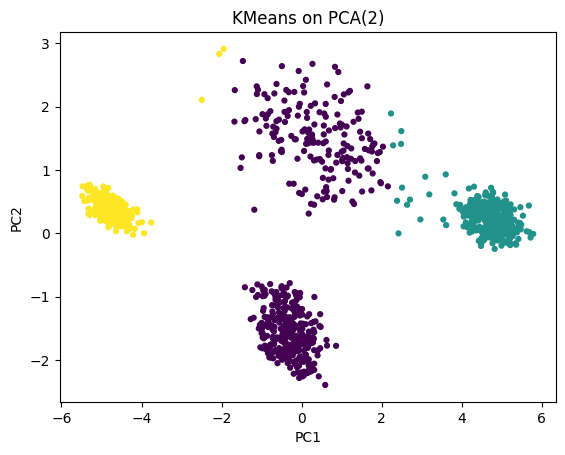

In [18]:
plt.scatter(X2[:,0], X2[:,1], c=labels_km, s=12)
plt.title('KMeans on PCA(2)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

In [19]:
# ===============================
# Streamlit Export Setup (Stress)
# ===============================

# 1) Create export directory (same pattern as the prior project)
export_dir = Path("../my_streamlit_app/models")
export_dir.mkdir(parents=True, exist_ok=True)

# 2) Collect all *fitted* pipelines from results dicts
#    We merge any variable that looks like a results-dict with a 'pipelines' key,
#    e.g., results, results_base, results_ros, results_rus, results_smt, etc.
all_pipelines = {}
for var_name, var_val in list(globals().items()):
    if isinstance(var_val, dict) and "pipelines" in var_val:
        for model_name, pipe in var_val["pipelines"].items():
            all_pipelines[model_name] = pipe

if not all_pipelines:
    raise RuntimeError("No fitted pipelines found. Make sure you ran run_models_with_importances(...) earlier.")

# 3) Optionally add a single 'best' alias if there is one
best_model_name = "AdaBoost"
if best_model_name in all_pipelines:
    all_pipelines["BestModel"] = all_pipelines[best_model_name]

# 4) Save each model as .pkl (joblib)
def safe_name(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9_+-]+", "_", name).strip("_")

for model_name, model_obj in all_pipelines.items():
    model_path = export_dir / f"{safe_name(model_name)}.pkl"
    joblib.dump(model_obj, model_path)

print(f"Saved {len(all_pipelines)} pipelines to: {export_dir}")

# 5) Save feature names used during training
if hasattr(X_train, "columns"):
    feature_names = X_train.columns.tolist()
else:
    # Fallback: if X_train is ndarray, try to infer from metadata or stop
    raise ValueError("X_train has no columns attribute. Please ensure X_train is a pandas DataFrame with column names.")
joblib.dump(feature_names, export_dir / "feature_names.pkl")
print("Saved feature_names.pkl")

# 6) Save test set for Streamlit evaluation
target_col = "stress_level"
test_df = pd.DataFrame(X_test, columns=feature_names) if not hasattr(X_test, "columns") else X_test.copy()
test_df[target_col] = y_test if getattr(y_test, "name", None) == target_col else pd.Series(y_test).rename(target_col).values
test_df.to_csv(export_dir / "test_set.csv", index=False)
print("Saved test_set.csv")

# 7) Save a metrics summary JSON (accuracy on test for each saved pipeline)
metrics = {}
for model_name, pipe in all_pipelines.items():
    try:
        y_pred = pipe.predict(test_df[feature_names])
        acc = float(accuracy_score(test_df[target_col], y_pred))
        metrics[model_name] = {"accuracy": acc}
    except Exception as e:
        metrics[model_name] = {"error": str(e)}
(Path(export_dir) / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("Saved metrics.json")


Saved 7 pipelines to: ..\my_streamlit_app\models
Saved feature_names.pkl
Saved test_set.csv
Saved metrics.json
